# Analyzing accesses of a single journal with Ratchet and ArticleMeta

This is the information about the analysis:

In [1]:
# Selected journal
collection = "scl"
journal_issn = "1808-2432"

In [2]:
# Configuration of this analysis
today = __import__("datetime").date.today()          # Or a "YYYY-MM-DD" string
num_threads = 20                # Number of simultaneous downloads / open files
fields = ["abstract", "html", "pdf", "pdfsite"]  # Access fields to be compared

The `today` value is used only to store the downloaded data.
Set it to a fixed string to freeze the input files and results.
The data won't be downloaded twice a day,
unless you remove the contents
from the `YYYY-MM-DD_ratchet` and `YYYY-MM-DD_articlemeta` directories.

We'll require `matplotlib` to show the plots in this notebook:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Functions to get data from Ratchet and ArticleMeta 

These functions get the access data from the Ratchet API
and the journal/article data from the ArticleMeta API.
They're based on a previous notebook (created on 2019-08-15)
and on the 8th notebook from the [SciELO 20 Years WG6](
  https://github.com/scieloorg/scielo20gt6
).

In [4]:
from functools import wraps
from multiprocessing.pool import ThreadPool
import os
import re
from urllib.request import urlopen

In [5]:
import pandas as pd
import ujson

In [6]:
def build_dataframe_from_dict(ratchet_dict, is_journal=True):
    columns = ["total", "abstract", "html", "pdf",
               "pdfsite", "toc", "issues"]
    if is_journal:
        columns.append("journal")
    dicts = {
        "total": ratchet_dict,
        "pdfsite": ratchet_dict.get("other", {}).get("pdfsite", {}),
        **{key: ratchet_dict.get(key, {})
           for key in columns if key not in ["total", "pdfsite"]},
    }
    series = []
    result = pd.DataFrame()
    for key, jdata in dicts.items():
        pairs = [(pd.Timestamp(f"{pyear[1:]}-{pmonth[1:]}-{pday[1:]}"), count)
            for pyear, ydata in jdata.items()
             if re.match(r"y\d\d\d\d", pyear)
            for pmonth, mdata in ydata.items()
             if re.match(r"m\d\d", pmonth)
            for pday, count in mdata.items()
             if re.match(r"d\d\d", pday)
        ]
        if pairs:
            dates, counts = zip(*pairs)
            series.append(pd.Series(counts, index=dates).rename(key))
    result = pd.DataFrame(series, dtype=object).reindex(columns).T
    result[result.isna()] = 0
    return pd.DataFrame(result, dtype=int).rename_axis("date")

In [7]:
def json_cache(directory):
    os.makedirs(directory, exist_ok=True)
    def decorator(func):
        @wraps(func)
        def wrapper(*args):
            fname = os.path.join(directory, "_".join(map(str, args)) + ".json")
            if os.path.exists(fname):
                with open(fname) as file_obj:
                    return ujson.load(file_obj)
            result = func(*args)
            with open(fname, "w") as file_obj:
                ujson.dump(result, file_obj)
            return result
        return wrapper
    return decorator

In [8]:
@json_cache(f"{today}_articlemeta")
def get_raw_metadata(entity, collection, issn):
    suffix = entity.replace("_", "/")
    url = f"http://articlemeta.scielo.org/api/v1/{suffix}/" \
          f"?collection={collection}&issn={issn}"
    return ujson.load(urlopen(url))

In [9]:
@json_cache(f"{today}_ratchet")
def get_raw_access_data(entity, value):
    url = f"http://ratchet.scielo.org/api/v1/{entity}s/{value}/"
    return ujson.load(urlopen(url))

In [10]:
def get_journal_access_df(issn):
    raw_dict_data = get_raw_access_data("journal", issn)
    return build_dataframe_from_dict(raw_dict_data)

In [11]:
def get_article_access_df(pid):
    raw_dict_data = get_raw_access_data("article", pid)
    return build_dataframe_from_dict(raw_dict_data, is_journal=False)

# Getting the journal title

We can get the journal metadata from the ArticleMeta,
and it includes the title.

In [12]:
journal_metadata = get_raw_metadata("journal", collection, journal_issn)
journal_title = journal_metadata[0]["v100"][0]["_"]
journal_title

'Revista Direito GV'

# Plotting the journal access data

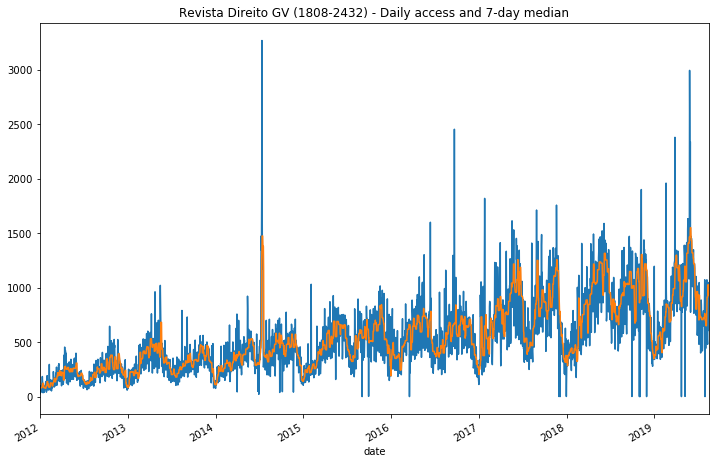

In [13]:
journal_access = get_journal_access_df(journal_issn).assign(
    _fields=lambda df: df[fields].T.sum(),
)
journal_access["_fields"].plot(figsize=(12, 8))
journal_access["_fields"].rolling(window=7).median().plot(
    figsize=(12, 8),
    title=f"{journal_title} ({journal_issn}) - Daily access and 7-day median",
);

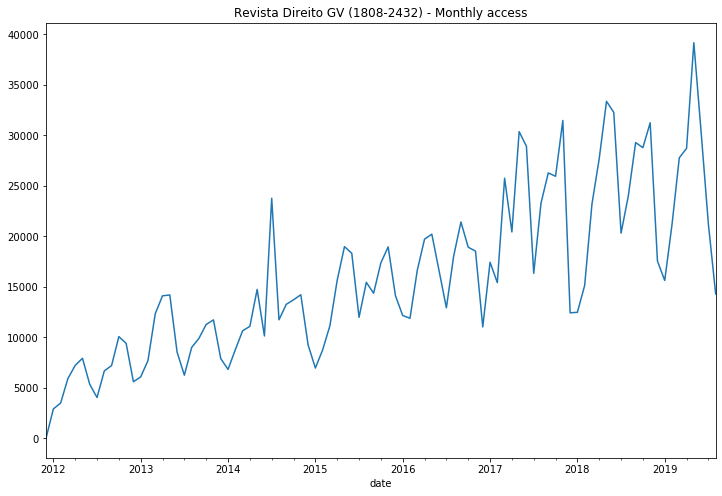

In [14]:
journal_access["_fields"].groupby(pd.Grouper(freq="M")).sum().plot(
    figsize=(12, 8),
    title=f"{journal_title} ({journal_issn}) - Monthly access",
);

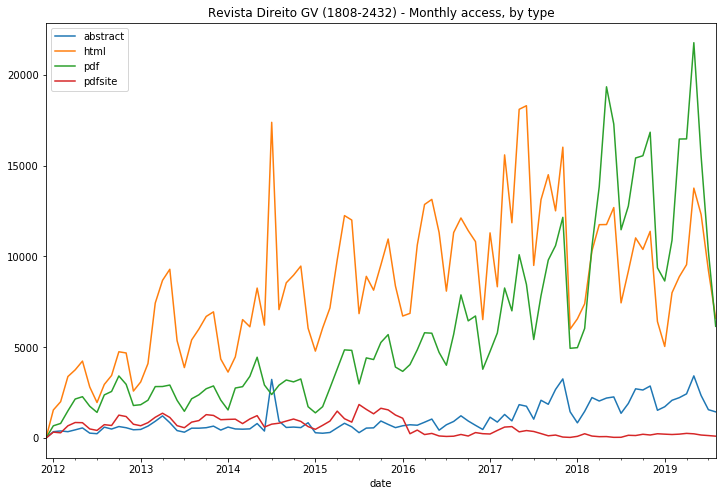

In [15]:
journal_access[fields].groupby(pd.Grouper(freq="M")).sum().plot(
    figsize=(12, 8),
    title=f"{journal_title} ({journal_issn}) - Monthly access, by type",
);

# Getting the articles' PIDs for the given journal

How many articles are there?

In [16]:
article_identifiers = get_raw_metadata("article_identifiers",
                                       collection, journal_issn)
pids = [obj["code"] for obj in article_identifiers["objects"]]
len(pids)

333

# Getting, summing and plotting the access data for each article

In [17]:
with ThreadPool(num_threads) as pool:
    articles_access_sum = (
        pd.concat(pool.map(get_article_access_df, pids))
        .reset_index()
        .groupby("date")
        .sum()
    ).assign(
        _fields=lambda df: df[fields].T.sum(),
    )

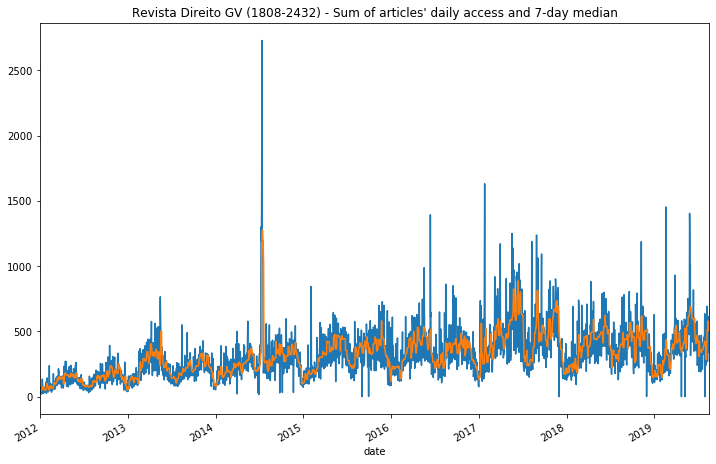

In [18]:
articles_access_sum["_fields"].plot(figsize=(12, 8))
articles_access_sum["_fields"].rolling(window=7).median().plot(
    figsize=(12, 8),
    title=f"{journal_title} ({journal_issn}) - "
           "Sum of articles' daily access and 7-day median",
);

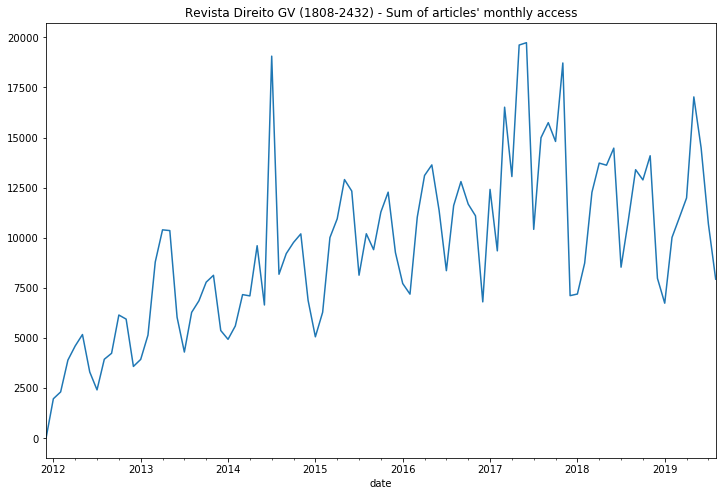

In [19]:
articles_access_sum["_fields"].groupby(pd.Grouper(freq="M")).sum().plot(
    figsize=(12, 8),
    title=f"{journal_title} ({journal_issn}) - "
           "Sum of articles' monthly access",
    );

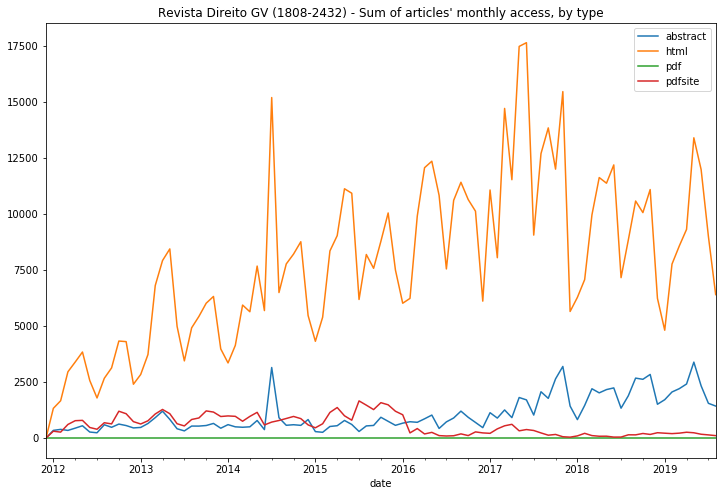

In [20]:
articles_access_sum[fields].groupby(pd.Grouper(freq="M")).sum().plot(
    figsize=(12, 8),
    title=f"{journal_title} ({journal_issn}) - "
           "Sum of articles' monthly access, by type",
);

# Difference histogram

How different is the journal access data from the sum of articles access data?

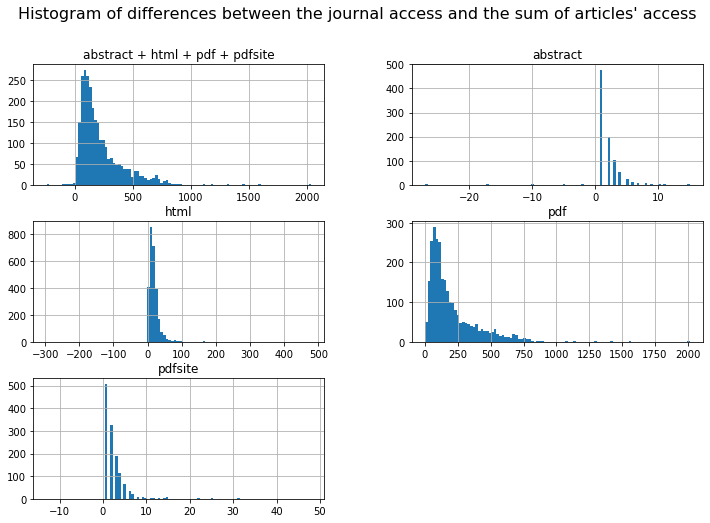

In [21]:
(
    journal_access[["_fields"] + fields] -
    articles_access_sum[["_fields"] + fields]
).replace({0: float("nan")}).hist(
    bins=100,
    figsize=(12, 8),
)
plt.gcf().axes[0].set(title=" + ".join(fields))
plt.gcf().suptitle(
    "Histogram of differences between the journal access "
    "and the sum of articles' access",
    fontsize=16,
);